# Face Mask Detection
 (Dataset from https://www.kaggle.com/datasets/shiekhburhan/face-mask-dataset?resource=download)

In [1]:
import tensorflow as tf
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Grab Data

Data is stored in Google Drive. We will use a 80/20 split for model evaluation, with no validation set for tuning parameters.. just a single and final evaluation at the end of training. 

In [2]:
train_data = tf.keras.utils.image_dataset_from_directory(
    'gdrive/My Drive/face_mask',
    labels='inferred',
    color_mode='grayscale',
    label_mode = 'categorical',
    image_size=(128, 128),
    shuffle=True,
    batch_size=128,
    validation_split=0.2,
    subset="training",
    seed=123
)

test_data = tf.keras.utils.image_dataset_from_directory(
    'gdrive/My Drive/face_mask',
    labels='inferred',
    color_mode='grayscale',
    label_mode = 'categorical',
    image_size=(128, 128),
    shuffle=True,
    batch_size=128,
    validation_split=0.2,
    subset="validation",
    seed=123
)

AUTOTUNE = tf.data.AUTOTUNE

train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)
test_data = test_data.cache().prefetch(buffer_size=AUTOTUNE)

Found 14536 files belonging to 3 classes.
Using 11629 files for training.
Found 14536 files belonging to 3 classes.
Using 2907 files for validation.


In [ ]:
print(train_data.class_names)
print(test_data.class_names)

['incorrect_mask', 'with_mask', 'without_mask']
['incorrect_mask', 'with_mask', 'without_mask']


In [ ]:
train_data.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

# Create Model

This is a very simple CNN

In [151]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from tensorflow.keras import layers, models, Model


model = models.Sequential()
model.add(layers.Rescaling(1./255))
model.add(layers.Conv2D(16, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

model.compile(
  optimizer='adam',
  loss=tf.keras.losses.CategoricalCrossentropy(),
  metrics=['accuracy', 'Precision', 'Recall'])

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)


history = model.fit(
  train_data,
  epochs=50,
  callbacks=[callback],
  workers=2
)

Epoch 1/50
91/91 [==============================] - 3s 28ms/step - loss: 0.6455 - accuracy: 0.7301 - precision: 0.8324 - recall: 0.5679
Epoch 2/50
91/91 [==============================] - 3s 28ms/step - loss: 0.3110 - accuracy: 0.8880 - precision: 0.8987 - recall: 0.8773
Epoch 3/50
91/91 [==============================] - 3s 28ms/step - loss: 0.2485 - accuracy: 0.9127 - precision: 0.9185 - recall: 0.9057
Epoch 4/50
91/91 [==============================] - 3s 28ms/step - loss: 0.1960 - accuracy: 0.9317 - precision: 0.9363 - recall: 0.9269
Epoch 5/50
91/91 [==============================] - 3s 28ms/step - loss: 0.1620 - accuracy: 0.9426 - precision: 0.9477 - recall: 0.9376
Epoch 6/50
91/91 [==============================] - 3s 28ms/step - loss: 0.1437 - accuracy: 0.9510 - precision: 0.9556 - recall: 0.9466
Epoch 7/50
91/91 [==============================] - 3s 28ms/step - loss: 0.1137 - accuracy: 0.9622 - precision: 0.9667 - recall: 0.9588
Epoch 8/50
91/91 [==============================

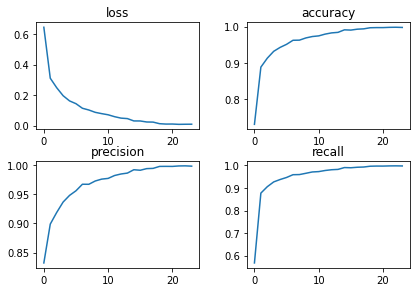

In [160]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 2)
fig.tight_layout()
ax[0,0].plot(history.history['loss'])
ax[0,0].title.set_text('loss')
ax[0,1].plot(history.history['accuracy'])
ax[0,1].title.set_text('accuracy')
ax[1,0].plot(history.history['precision'])
ax[1,0].title.set_text('precision')
ax[1,1].plot(history.history['recall'])
ax[1,1].title.set_text('recall')

# Evaluate model!

We will make predictions on our test set which we got earlier. The output will be loss, accuracy, precision, and recall

In [161]:
model.evaluate(test_data)

23/23 [==============================] - 1s 19ms/step - loss: 0.4164 - accuracy: 0.9198 - precision: 0.9204 - recall: 0.9192


[0.41643109917640686, 0.919848620891571, 0.920427143573761, 0.9191606640815735]

In [162]:
from sklearn.metrics import classification_report
import numpy as np

test_label = np.concatenate([y for x, y in test_data], axis=0)
predict=model.predict(test_data) 
predicted_classes=np.argmax(predict,axis=1)
print(classification_report(np.argmax(test_label, axis=1), predicted_classes, target_names=['incorrect_mask', 'with_mask', 'without_mask']))

                precision    recall  f1-score   support

incorrect_mask       0.97      0.95      0.96      1012
     with_mask       0.89      0.89      0.89       942
  without_mask       0.90      0.92      0.91       953

      accuracy                           0.92      2907
     macro avg       0.92      0.92      0.92      2907
  weighted avg       0.92      0.92      0.92      2907



# Feature Maps

We will use an image I randomly selected to visualize the feature maps

In [163]:
model.layers

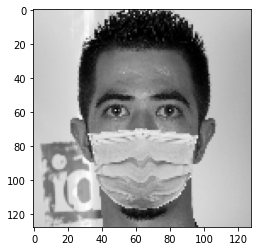

In [164]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

image = load_img('gdrive/MyDrive/face_mask/with_mask/simple13.jpg' , color_mode='grayscale', target_size=(128,128))
plt.imshow(image, cmap='gray')
# convert the image to an array
image = img_to_array(image)
# expand dimensions so that it represents a single 'sample'
image = np.expand_dims(image, axis=0)

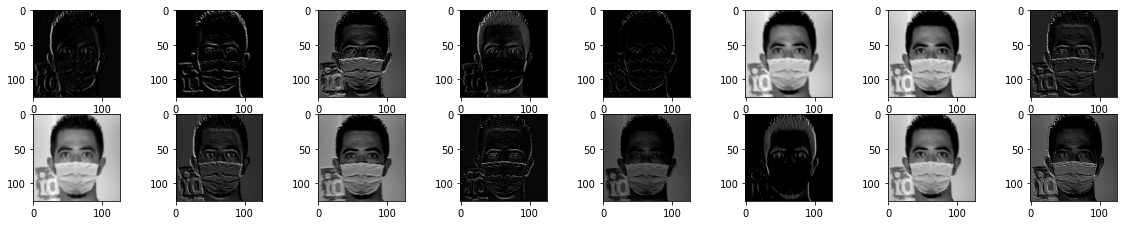

In [165]:
temp_model = Model(inputs=model.inputs , outputs=model.layers[1].output)
features = temp_model.predict(image)

fig = plt.figure(figsize=(20,15))
for i in range(1,features.shape[3]+1):

    plt.subplot(8,8,i)
    plt.imshow(features[0,:,:,i-1] , cmap='gray')
    
plt.show()

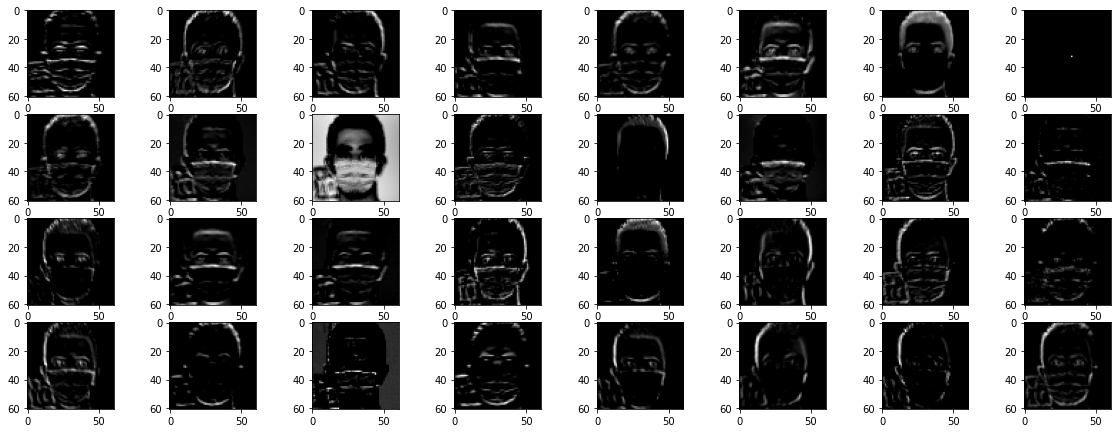

In [166]:
temp_model = Model(inputs=model.inputs , outputs=model.layers[3].output)

features = temp_model.predict(image)

fig = plt.figure(figsize=(20,15))
for i in range(1,features.shape[3]+1):

    plt.subplot(8,8,i)
    plt.imshow(features[0,:,:,i-1] , cmap='gray')
    
plt.show()

# Evaluating the model on pictures of myself!

I thought this would be a fun way to see how effective the model is given photos of myself (not included in training or test sets)

## Without Mask

Class = 2

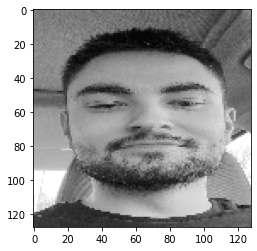

In [167]:
temp_model = Model(inputs=model.inputs , outputs=model.layers[1].output)

image = load_img('unnamed-4.jpg' , color_mode='grayscale', target_size=(128,128))
plt.imshow(image, cmap='gray')
# convert the image to an array
image = img_to_array(image)
# expand dimensions so that it represents a single 'sample'
image = np.expand_dims(image, axis=0)

In [168]:
np.argmax(model.predict(image)) # woohoo without mask predicted properly!

2

In [169]:
model.predict(image) # confident prediction

array([[4.2233902e-10, 5.2162058e-10, 1.0000000e+00]], dtype=float32)

## With Mask

Class = 1

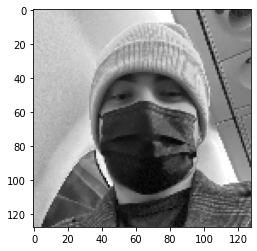

In [170]:
temp_model = Model(inputs=model.inputs , outputs=model.layers[1].output)

image = load_img('unnamed-3.jpg' , color_mode='grayscale', target_size=(128,128))
plt.imshow(image, cmap='gray')
# convert the image to an array
image = img_to_array(image)
# expand dimensions so that it represents a single 'sample'
image = np.expand_dims(image, axis=0)

In [171]:
np.argmax(model.predict(image)) # woohoo with mask predicted properly!

1

In [172]:
model.predict(image) # confident prediction

array([[8.639986e-04, 9.989672e-01, 1.689200e-04]], dtype=float32)

## Incorrect Mask

Class = 0

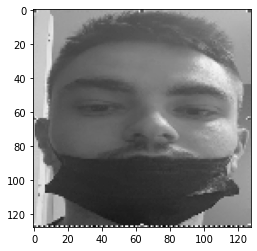

In [173]:
temp_model = Model(inputs=model.inputs , outputs=model.layers[1].output)

image = load_img('Untitled-13.jpg' , color_mode='grayscale', target_size=(128,128))
plt.imshow(image, cmap='gray')
# convert the image to an array
image = img_to_array(image)
# expand dimensions so that it represents a single 'sample'
image = np.expand_dims(image, axis=0)

In [174]:
np.argmax(model.predict(image))  # woohoo without mask predicted properly!

0

In [175]:
model.predict(image) # hmm.. not as sure as the others! but still right none the less

array([[0.54099506, 0.341239  , 0.11776596]], dtype=float32)